In [1]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report,classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

/Users/sijiehuang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Load Data and Data Preprocessing

In [2]:
import os
import shutil
import random
import pathlib
from collections import defaultdict


def split_ucf_101_subset(dataset_path, splits, output_dir, num_classes=None, class_names=None):
    """Create a subset of the UCF101 dataset and split into train, val, and test sets.

    Args:
        dataset_path: Path to the UCF101 dataset
        splits: Dict with split percentages, e.g., {"train": 70, "val": 15, "test": 15}
        output_dir: Output folder path
        num_classes: Optional, number of classes to use
        class_names: Optional, explicit list of class names to include

    Returns:
        Dict mapping split names to output directories
    """
    output_dir = pathlib.Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    if sum(splits.values()) != 100:
        raise ValueError(f"Split percentages must sum to 100, got {sum(splits.values())}")

    ucf_dir = os.path.join(dataset_path, "UCF101", "UCF-101")
    if not os.path.exists(ucf_dir):
        raise FileNotFoundError(f"UCF-101 directory not found at {ucf_dir}")

    all_classes = sorted([d for d in os.listdir(ucf_dir) if os.path.isdir(os.path.join(ucf_dir, d))])

    if class_names:
        selected_classes = [cls for cls in class_names if cls in all_classes]
        missing = set(class_names) - set(selected_classes)
        if missing:
            print(f"Warning: Some specified classes not found in dataset: {missing}")
    elif num_classes:
        if num_classes > len(all_classes):
            print(f"Warning: Requested {num_classes} classes but only {len(all_classes)} available.")
        selected_classes = all_classes[:num_classes]
    else:
        raise ValueError("Either class_names or num_classes must be provided.")

    files_for_class = defaultdict(list)
    for cls in selected_classes:
        class_dir = os.path.join(ucf_dir, cls)
        for file in os.listdir(class_dir):
            if file.endswith(".avi"):
                files_for_class[cls].append(os.path.join(class_dir, file))
        random.shuffle(files_for_class[cls])

    split_dirs = {}
    for split_name in splits:
        split_dir = output_dir / split_name
        split_dir.mkdir(exist_ok=True)
        split_dirs[split_name] = split_dir
        for cls in selected_classes:
            os.makedirs(split_dir / cls, exist_ok=True)

    for cls, files in files_for_class.items():
        total = len(files)
        start = 0
        for i, (split_name, pct) in enumerate(splits.items()):
            if i == len(splits) - 1:
                split_files = files[start:]
            else:
                count = int(total * pct / 100)
                split_files = files[start:start + count]
                start += count
            for file in split_files:
                dst = split_dirs[split_name] / cls / os.path.basename(file)
                shutil.copy2(file, dst)
            print(f"{split_name}: Copied {len(split_files)} files for class {cls}")

    return split_dirs

# Example usage:
import pathlib

if __name__ == "__main__":
    DATASET_PATH = "/Users/sijiehuang/.cache/kagglehub/datasets/pevogam/ucf101/versions/1"
    
    # ✅ Specify desired class names
    selected_classes = [
        "ApplyEyeMakeup", "PlayingDhol", "BabyCrawling", "Haircut",
        "SkyDiving", "Surfing", "Rafting", "CricketShot", "ShavingBeard"
    ]

    output_dir = pathlib.Path('./UCF101_subset/')

    # ✅ Pass selected class names instead of num_classes
    subset_paths = split_ucf_101_subset(
    dataset_path=DATASET_PATH,
    class_names=selected_classes,
    splits={"train": 70, "val": 15, "test": 15},
    output_dir=output_dir)

    print("Dataset splits created at:")
    for split_name, split_dir in subset_paths.items():
        print(f"  {split_name}: {split_dir}")

train: Copied 101 files for class ApplyEyeMakeup
val: Copied 21 files for class ApplyEyeMakeup
test: Copied 23 files for class ApplyEyeMakeup
train: Copied 114 files for class PlayingDhol
val: Copied 24 files for class PlayingDhol
test: Copied 26 files for class PlayingDhol
train: Copied 92 files for class BabyCrawling
val: Copied 19 files for class BabyCrawling
test: Copied 21 files for class BabyCrawling
train: Copied 91 files for class Haircut
val: Copied 19 files for class Haircut
test: Copied 20 files for class Haircut
train: Copied 77 files for class SkyDiving
val: Copied 16 files for class SkyDiving
test: Copied 17 files for class SkyDiving
train: Copied 88 files for class Surfing
val: Copied 18 files for class Surfing
test: Copied 20 files for class Surfing
train: Copied 77 files for class Rafting
val: Copied 16 files for class Rafting
test: Copied 18 files for class Rafting
train: Copied 116 files for class CricketShot
val: Copied 25 files for class CricketShot
test: Copied 26

In [3]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame



def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


In [4]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
def get_train_val_test(n_frames=10, batch_size=2):
    output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

    train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)
    val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)
    test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                         output_signature = output_signature)

    AUTOTUNE = tf.data.AUTOTUNE
    
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

    train_ds = train_ds.batch(2)
    val_ds = val_ds.batch(2)
    test_ds = test_ds.batch(2)

    return train_ds, val_ds, test_ds

### EDA

In [6]:
import os
from collections import defaultdict

def count_videos_per_class(base_dir):
    class_counts = defaultdict(int)
    for cls in os.listdir(base_dir):
        cls_dir = os.path.join(base_dir, cls)
        if os.path.isdir(cls_dir):
            class_counts[cls] = len(os.listdir(cls_dir))
    return class_counts

splits = ['train', 'val', 'test']
root = 'UCF101_subset'
counts = {split: count_videos_per_class(os.path.join(root, split)) for split in splits}

# Total stats
for split in splits:
    print(f"{split}: {sum(counts[split].values())} videos in {len(counts[split])} classes")

train: 868 videos in 9 classes
val: 182 videos in 9 classes
test: 196 videos in 9 classes


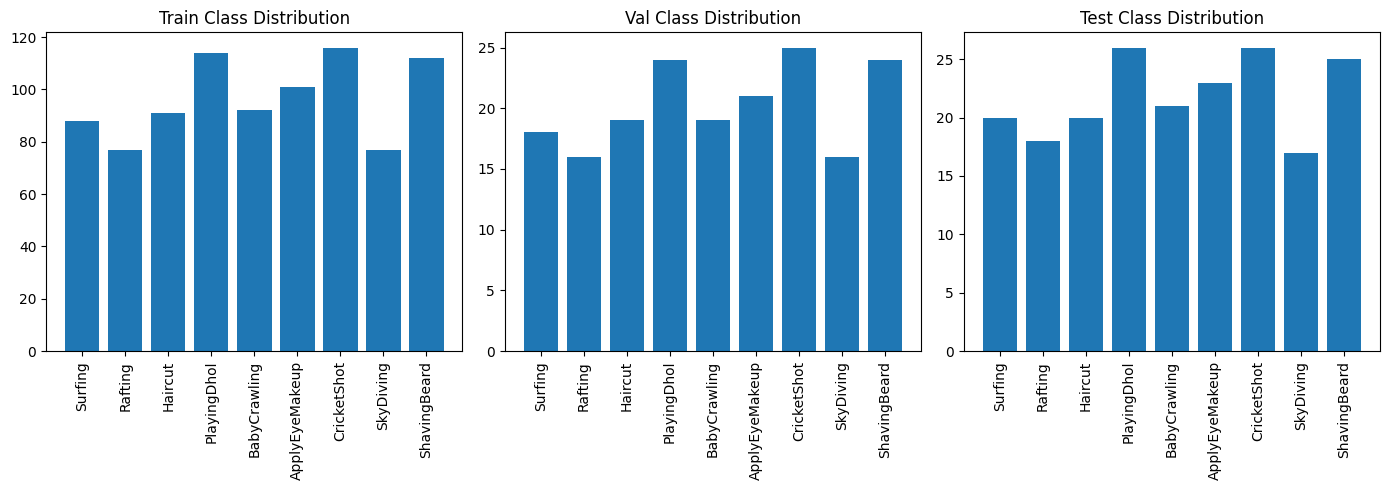

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
for i, split in enumerate(splits):
    plt.subplot(1, 3, i + 1)
    plt.bar(counts[split].keys(), counts[split].values())
    plt.xticks(rotation=90)
    plt.title(f"{split.capitalize()} Class Distribution")
    plt.tight_layout()

plt.show()

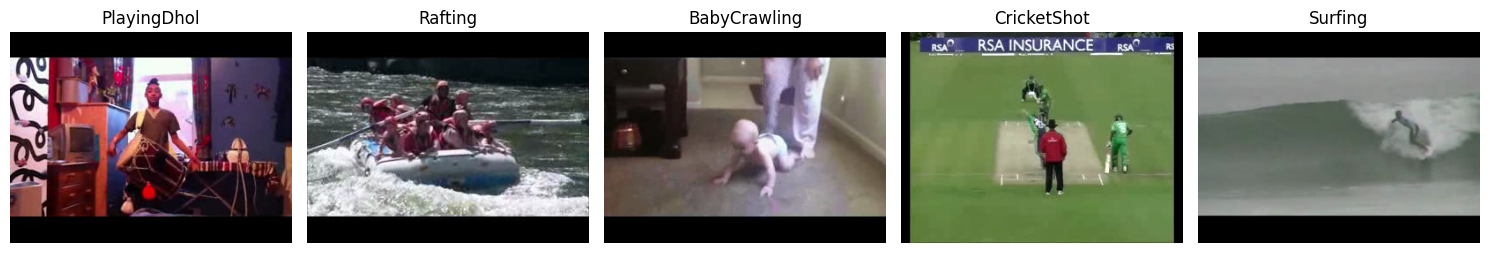

In [8]:
# sample a few frames from the dataset
def sample_frame(video_path, frame_no=10):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    ret, frame = cap.read()
    cap.release()
    return frame if ret else None

sample_classes = random.sample(list(counts['train'].keys()), 5)
plt.figure(figsize=(15, 6))

for i, cls in enumerate(sample_classes):
    video_list = os.listdir(os.path.join(root, 'train', cls))
    sample_vid = os.path.join(root, 'train', cls, random.choice(video_list))
    frame = sample_frame(sample_vid)
    if frame is not None:
        plt.subplot(1, 5, i+1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(cls)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Turn the dataset into frames
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

2025-05-23 16:29:50.100391: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-23 16:29:50.100409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-23 16:29:50.100417: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1748035790.100427 2207225 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1748035790.100443 2207225 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


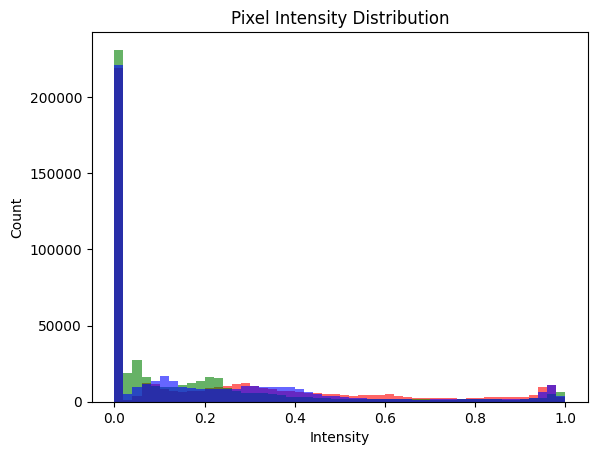

2025-05-23 16:29:50.629903: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [10]:
# Pixel Intensity Histogram (Across All Frames in a Video)
def show_pixel_distribution(ds, sample_idx=0):
    for i, (video, label) in enumerate(ds.take(sample_idx + 1)):
        if i == sample_idx:
            video = video.numpy()
            # Combine all frames into one array
            pixels = video.reshape(-1, 3)  # (total_pixels, 3)
            colors = ('r', 'g', 'b')
            for j, col in enumerate(colors):
                plt.hist(pixels[:, j], bins=50, color=col, alpha=0.6)
            plt.title("Pixel Intensity Distribution")
            plt.xlabel("Intensity")
            plt.ylabel("Count")
            plt.show()

show_pixel_distribution(train_ds, sample_idx=1)

In [11]:
# Mean / Std of frames across dataset
def get_mean_std(ds, num_batches=100):
    means = []
    stds = []
    for i, (video, _) in enumerate(ds.take(num_batches)):
        vid_np = video.numpy()
        means.append(np.mean(vid_np))
        stds.append(np.std(vid_np))
    print(f"Mean pixel intensity: {np.mean(means):.4f}")
    print(f"Std pixel intensity: {np.mean(stds):.4f}")

get_mean_std(train_ds)

Mean pixel intensity: 0.2454
Std pixel intensity: 0.2744


2025-05-23 16:30:00.633851: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


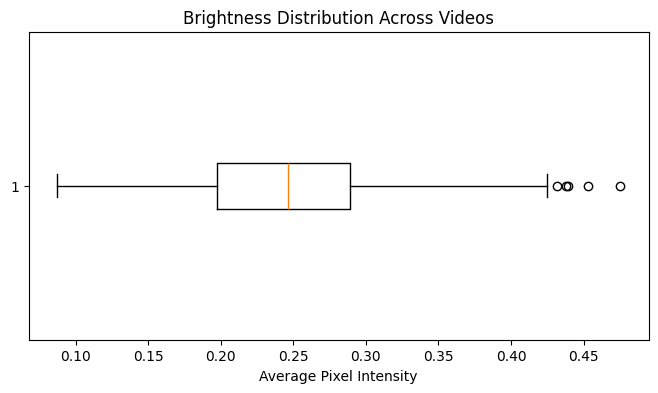

In [12]:
# frame brightness
def plot_brightness_outliers(ds, num_videos=100):
    brightness = []
    for video, _ in ds.take(num_videos):
        avg_brightness = tf.reduce_mean(video).numpy()
        brightness.append(avg_brightness)

    plt.figure(figsize=(8, 4))
    plt.boxplot(brightness, vert=False)
    plt.title("Brightness Distribution Across Videos")
    plt.xlabel("Average Pixel Intensity")
    plt.show()

plot_brightness_outliers(train_ds)

In [15]:
import os
import pandas as pd

def extract_video_stats(root_dir):
    stats = []

    for split in ['train', 'test', 'val']:
        split_path = os.path.join(root_dir, split)
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue
            for file in os.listdir(class_path):
                if file.endswith('.avi'):
                    video_path = os.path.join(class_path, file)
                    cap = cv2.VideoCapture(video_path)
                    if cap.isOpened():
                        frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                        fps = cap.get(cv2.CAP_PROP_FPS)
                        duration = frames / fps if fps > 0 else None
                        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        stats.append({
                            "split": split,
                            "class": class_name,
                            "video": file,
                            "frames": frames,
                            "fps": fps,
                            "duration_sec": duration,
                            "resolution": f"{width}x{height}"
                        })
                        cap.release()

    return pd.DataFrame(stats)

In [16]:
video_stats = extract_video_stats("ucf101_subset")

In [19]:
video_stats.head()

,split,class,video,frames,fps,duration_sec,resolution
0,train,Surfing,v_Surfing_g16_c04.avi,248,25.0,9.92,320x240
1,train,Surfing,v_Surfing_g06_c04.avi,139,25.0,5.56,320x240
2,train,Surfing,v_Surfing_g20_c06.avi,259,25.0,10.36,320x240
3,train,Surfing,v_Surfing_g07_c01.avi,264,25.0,10.56,320x240
4,train,Surfing,v_Surfing_g21_c03.avi,137,25.0,5.48,320x240


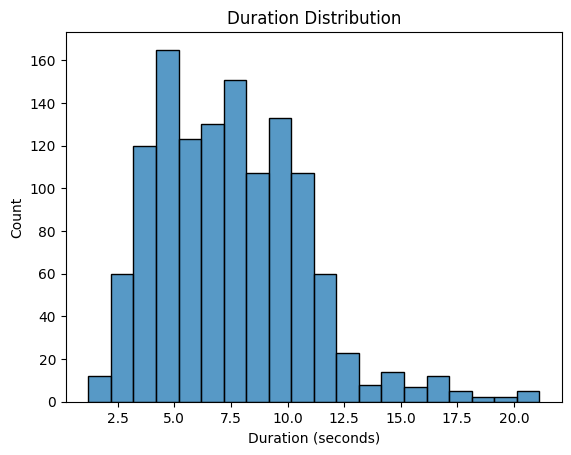

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histogram of frame counts
sns.histplot(video_stats['duration_sec'], bins=20)
plt.title("Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.show()